# [Formação: Deep Learning com Pytorch](https://unibb.alura.com.br/formacao-deep-learning-pytorch)

In [1]:
import re
import os
import nltk
import torch
import string
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

from random import choice
from torch import nn, optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from skimage import io, color, transform, data


%matplotlib inline
%config IPCompleter.use_jedi = False

___
## Parte 3/3: Dados sequenciais em deep learning

### [Redes Neurais Recorrentes: Deep Learning com Pytorch](https://unibb.alura.com.br/course/rnn-redes-neurais-recorrentes-deep-learning-pytorch)

- ### Caracteres

Os dados podem ser obtidos [aqui](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

In [2]:
DIR_DADOS = 'datasets/nomes-nacionalidades/names/'

In [3]:
!sort $DIR_DADOS/Arabic.txt | head -n 3

Abadi
Abadi
Abadi


In [4]:
!wc -l datasets/nomes-nacionalidades/names/* | tail -n 1

 20074 total


In [5]:
print(f'{len(os.listdir(DIR_DADOS))} arquivos')

18 arquivos


Carregar os dados:

In [6]:
def limpa_texto(nomes):
    nomes = nomes.split('\n')
    nomes = [unicodedata.normalize('NFKD', nome).encode('ascii', 'ignore').decode('utf8') for nome in nomes if len(nome) >= 1]
    nomes = [re.sub(pattern="[^a-zA-Z -']", repl='', string=nome) for nome in nomes]
    return nomes

def le_arquivo(path_arquivo):
    with open(path_arquivo, 'r') as f:
        return limpa_texto(f.read())

In [7]:
classes = []
dados = []

for f in os.listdir(DIR_DADOS):
    nacionalidade = f.replace('.txt', '').lower()
    classes.append(nacionalidade)
    nomes = sorted(le_arquivo(DIR_DADOS + f))
    nomes = [[n, nacionalidade] for n in nomes]
    dados.append(nomes)

classes = sorted(classes)

In [8]:
print(f'{sum(len(d) for d in dados)} nomes lidos')

20074 nomes lidos


Explorando os dados:

In [9]:
_ = []
for d in dados:
    _.extend(d)

df = pd.DataFrame(data=_, columns=['nome', 'nac'])
df.shape

(20074, 2)

In [10]:
df['tam'] = df['nome'].apply(len)

In [11]:
df.tail(10)

,nome,nac,tam
20064,Wallace,scottish,7
20065,Watson,scottish,6
20066,Watt,scottish,4
20067,White,scottish,5
20068,Whyte,scottish,5
20069,Williamson,scottish,10
20070,Wilson,scottish,6
20071,Wood,scottish,4
20072,Wright,scottish,6
20073,Young,scottish,5


In [12]:
df['tam'].describe()

count    20074.000000
mean         7.152486
std          2.099244
min          2.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         19.000000
Name: tam, dtype: float64

In [13]:
df['nac'].describe()

count       20074
unique         18
top       russian
freq         9408
Name: nac, dtype: object

In [14]:
df['nac'].value_counts()

russian       9408
english       3668
arabic        2000
japanese       991
german         724
italian        709
czech          519
spanish        298
dutch          297
french         277
chinese        268
irish          232
greek          203
polish         139
scottish       100
korean          94
portuguese      74
vietnamese      73
Name: nac, dtype: int64

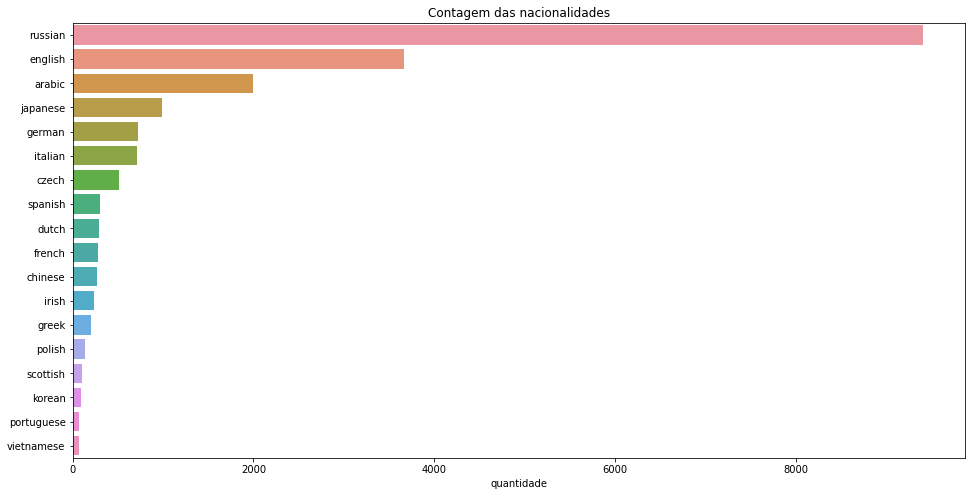

In [15]:
_ = dict(df['nac'].value_counts())

plt.figure(figsize=(16,8))

sns.barplot(x=[*_.values()], y=[*_.keys()], orient='h')

plt.title('Contagem das nacionalidades')
plt.xlabel('quantidade')
plt.show()

Transformações:

In [16]:
def classe2tensor(classe):
    pos = classes.index(classe)
    return torch.LongTensor([pos])

In [17]:
_ = dados[7][93]
_, classe2tensor(_[-1]), classes[12]

(['Sierzant', 'polish'], tensor([12]), 'polish')

In [18]:
dicionario = string.ascii_letters + ' -\''
len(dicionario), dicionario

(55, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ -'")

In [19]:
def nome2tensor(nome):
    nome_tns = np.zeros((len(nome), len(dicionario)))  # uma entrada no vetor PARA CADA letra
    for k,letra in enumerate(nome):
        try:
            nome_tns[k][dicionario.index(letra)] = 1
        except Exception as e:
            print(e, nome)
    return torch.Tensor(nome_tns)

In [20]:
nome2tensor('banco do brasil').shape, classe2tensor('portuguese')

(torch.Size([15, 55]), tensor([13]))

 Amostragem:

In [21]:
TAM_AMOSTRA = 50

def gerar_amostragem(lista_dados: list):  # permite repetição
    amostra = []
    for cat in dados:
        _ = []
        for i in range(TAM_AMOSTRA):
            _.append(choice(cat))
        amostra.append(_)
    return amostra

In [22]:
def amostra2tensor(amostra_dados: list):
    dados_tns = []
    classes_tns = []
    for cat in amostra_dados:
        for reg in cat:
            try:
                _dado = nome2tensor(reg[0])
                _classe = classe2tensor(reg[-1])
                dados_tns.append(_dado)
                classes_tns.append(_classe)
            except Exception as e:
                print(reg)
    return dados_tns, classes_tns

In [23]:
_ = gerar_amostragem(dados)
_d, _c = amostra2tensor(_)

len(_d), len(_c)

(900, 900)

- ### Arquitetura: RNN simples

In [24]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [25]:
DIM_INPUT = len(dicionario)
DIM_OUTPUT = len(df['nac'].unique())

DIM_INPUT, DIM_OUTPUT

(55, 18)

Modelo:

In [26]:
class CaracteresRNN(nn.Module):


    def __init__(self, dim_input, dim_hidden, dim_output):
        super(CaracteresRNN, self).__init__()

        self.dim_hidden = dim_hidden

        self.recorrente = nn.RNNCell(dim_input, dim_hidden)
        self.saida = nn.Linear(dim_hidden, dim_output)
        self.ativacao = nn.LogSoftmax(dim=1)


    def forward(self, nome):
        h = torch.zeros(1, self.dim_hidden)                 # hidden_state = B x F

        for letra in nome:                                  # nome.size() = [#letras, #dict]
            h = self.recorrente(letra.unsqueeze(0), h)

        saida = self.ativacao(self.saida(h))
        return saida

In [27]:
try:
    del modelo, loss_func, otimizador
except:
    pass

modelo = CaracteresRNN(DIM_INPUT, 256, DIM_OUTPUT)
loss_func = nn.NLLLoss()
otimizador = optim.Adam(modelo.parameters(), lr=1e-3, weight_decay=1e-7)


modelo, otimizador, loss_func

(CaracteresRNN(
   (recorrente): RNNCell(55, 256)
   (saida): Linear(in_features=256, out_features=18, bias=True)
   (ativacao): LogSoftmax(dim=1)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 1e-07
 ),
 NLLLoss())

In [28]:
def forward_rnn(X, Y, etapa, epoca):

    loss_epoca = []
    acuracia = 0.0

    for dado, rotulo in zip(X, Y):

        saida = modelo(dado)
        loss = loss_func(saida, rotulo)
        loss_epoca.append(loss)

        _, pred = torch.max(saida, axis=-1)
        acuracia += 1 if pred[0] == rotulo[0].item() else 0

        if etapa == 'treino':
            otimizador.zero_grad()
            loss.backward()
            otimizador.step()

    loss_epoca = np.array([x.item() for x in loss_epoca])
    acuracia = acuracia/float(len(X))

    _msg = f'Loss: {loss_epoca.mean():.2f} +- {loss_epoca.std():.2f}, Acurácia: {acuracia * 100:.2f}'
    if etapa == 'treino':
        print(f'## Epoch: {epoca} | {_msg}')
    else:
        print(f'-- Validação | {_msg}\n')

    return loss_epoca.mean(), acuracia

(A implementação do treino com poucos dados (amostras) não ficou tão boa, portanto, comentei)

In [29]:
# %%time

# EPOCHS = 100

# loss_treino, loss_teste = [], []
# acc_treino, acc_teste = [], []

# amostra = gerar_amostragem(dados)
# xtest, ytest = amostra2tensor(amostra)

# for epoch in range(EPOCHS):

#     amostra = gerar_amostragem(dados)
#     xtrain, ytrain = amostra2tensor(amostra)

#     # fazer um leve embaralhamento
#     if epoch % 2 == 0:
#         xtrain = xtrain[::-1]
#         ytrain = ytrain[::-1]
    
#     loss, acc = forward_rnn(X=xtrain, Y=ytrain, etapa='treino', epoca=epoch)
#     loss_treino.append(loss)
#     acc_treino.append(acc)

#     loss, acc = forward_rnn(X=xtest, Y=ytest, etapa='validacao', epoca=epoch)
#     loss_teste.append(loss)
#     acc_teste.append(acc)

In [30]:
df_nome_tns = df['nome'].apply(nome2tensor).values
df_nac_tns = df['nac'].apply(classe2tensor).values

In [31]:
xtrain, xtest, ytrain, ytest = train_test_split(df_nome_tns,
                                                df_nac_tns,
                                                stratify=df_nac_tns,
                                                test_size=.25,
                                                random_state=777)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((15055,), (15055,), (5019,), (5019,))

Para utilizar todos os dados da massa de treino, deveríamos iterar ao longo de 300 épocas. Em virtude da duração, dos recursos computacionais e dos resultados iniciais serem razoáveis, vamos iterar menos épocas.

_Note que o nosso `split` foi feito de forma estratificada!_

Treinamento:

In [34]:
%%time

EPOCHS = 50

loss_treino, loss_teste = [], []
acc_treino, acc_teste = [], []

j = 50  # janela

for e in range(EPOCHS):

    loss, acc = forward_rnn(X=xtrain[e*j:(e*j)+j], Y=ytrain[e*j:(e*j)+j], etapa='treino', epoca=e)
    loss_treino.append(loss)
    acc_treino.append(acc)

    loss, acc = forward_rnn(X=xtest, Y=ytest, etapa='validacao', epoca=e)
    loss_teste.append(loss)
    acc_teste.append(acc)

## Epoch: 0 | Loss: 1.32 +- 1.33, Acurácia: 60.00
-- Validação | Loss: 1.84 +- 1.09, Acurácia: 50.45

## Epoch: 1 | Loss: 1.81 +- 1.30, Acurácia: 44.00
-- Validação | Loss: 2.11 +- 2.39, Acurácia: 47.34

## Epoch: 2 | Loss: 1.46 +- 1.37, Acurácia: 56.00
-- Validação | Loss: 2.20 +- 2.30, Acurácia: 45.61

## Epoch: 3 | Loss: 2.06 +- 1.63, Acurácia: 52.00
-- Validação | Loss: 1.79 +- 1.60, Acurácia: 48.87

## Epoch: 4 | Loss: 1.65 +- 1.30, Acurácia: 46.00
-- Validação | Loss: 1.66 +- 1.44, Acurácia: 48.81

## Epoch: 5 | Loss: 1.91 +- 1.87, Acurácia: 48.00
-- Validação | Loss: 1.67 +- 1.58, Acurácia: 49.45

## Epoch: 6 | Loss: 1.27 +- 1.46, Acurácia: 62.00
-- Validação | Loss: 1.65 +- 1.56, Acurácia: 50.43

## Epoch: 7 | Loss: 1.58 +- 1.41, Acurácia: 58.00
-- Validação | Loss: 1.66 +- 1.68, Acurácia: 51.66

## Epoch: 8 | Loss: 1.27 +- 1.22, Acurácia: 58.00
-- Validação | Loss: 2.00 +- 2.07, Acurácia: 47.72

## Epoch: 9 | Loss: 1.78 +- 1.88, Acurácia: 58.00
-- Validação | Loss: 1.83 +- 1.9

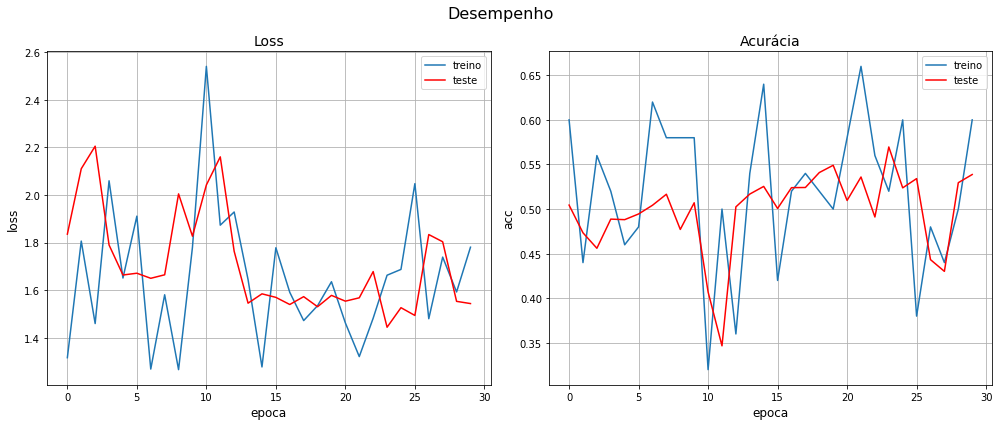

In [35]:
plt.figure(figsize=(14, 6))
plt.suptitle('Desempenho', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('Loss', fontsize=14)
sns.lineplot(x=range(EPOCHS), y=[x.item() for x in loss_treino], hue=['treino' for _ in range(EPOCHS)])
sns.lineplot(x=range(EPOCHS), palette=['r'], y=[x.item() for x in loss_teste], hue=['teste' for _ in range(EPOCHS)])
plt.xlabel('epoca', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Acurácia', fontsize=14)
sns.lineplot(x=range(EPOCHS), y=acc_treino, hue=['treino' for _ in range(EPOCHS)])
sns.lineplot(x=range(EPOCHS), y=acc_teste, palette=['r'], hue=['teste' for _ in range(EPOCHS)])
plt.xlabel('epoca', fontsize=12)
plt.ylabel('acc', fontsize=12)
plt.grid()

plt.tight_layout()
plt.show()

In [36]:
def predict(nome, top=3):
    tns = nome2tensor(nome)
    saida = modelo(tns)
    probas, idxs = saida.data.topk(top, 1, True)#, True)
#     print(f'>> {nome}')
    for proba,arg in zip(*probas, *idxs):
        p = proba.item()
        a = arg.item()
        c = classes[arg.item()]
        print(f'Proba: {p:.2f}\tClasse: {a}\tLabel: {c}')
    print()

In [37]:
for i in range(5):
    n, nac, = choice(df[['nome', 'nac']].values)
    print(f'{n} [{nac}]')
    predict(n)

Mingaleev [russian]
Proba: -0.18	Classe: 14	Label: russian
Proba: -2.96	Classe: 4	Label: english
Proba: -3.47	Classe: 10	Label: japanese

Noggins [english]
Proba: -1.35	Classe: 0	Label: arabic
Proba: -1.50	Classe: 4	Label: english
Proba: -2.52	Classe: 6	Label: german

Otroshenko [russian]
Proba: -0.25	Classe: 14	Label: russian
Proba: -2.72	Classe: 9	Label: italian
Proba: -3.89	Classe: 4	Label: english

Taguchi [japanese]
Proba: -1.50	Classe: 4	Label: english
Proba: -2.48	Classe: 6	Label: german
Proba: -2.59	Classe: 16	Label: spanish

Haik [arabic]
Proba: -0.90	Classe: 0	Label: arabic
Proba: -1.72	Classe: 4	Label: english
Proba: -2.30	Classe: 14	Label: russian



- ### GRU

In [41]:
class CaracteresGRU(nn.Module):


    def __init__(self, dim_input, dim_hidden, dim_output):
        super(CaracteresGRU, self).__init__()

        self.dim_hidden = dim_hidden

        self.recorrente = nn.GRU(dim_input, dim_hidden, batch_first=False)
        self.saida = nn.Linear(dim_hidden, dim_output)
        self.ativacao = nn.LogSoftmax(dim=1)


    def forward(self, nome):
        h = torch.zeros(1, 1, self.dim_hidden)              # hidden_state = L x B x F
        nome = nome.unsqueeze(1)
        saida, h  = self.recorrente(nome)
        saida = self.ativacao(self.saida(saida[-1]))
        return saida

In [42]:
try:
    del modelo, loss_func, otimizador
except:
    pass

modelo = CaracteresGRU(DIM_INPUT, 256, DIM_OUTPUT)
loss_func = nn.NLLLoss()
otimizador = optim.Adam(modelo.parameters(), lr=1e-3, weight_decay=1e-7)


modelo, otimizador, loss_func

(CaracteresGRU(
   (recorrente): GRU(55, 256)
   (saida): Linear(in_features=256, out_features=18, bias=True)
   (ativacao): LogSoftmax(dim=1)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 1e-07
 ),
 NLLLoss())

In [45]:
%%time

EPOCHS = 50

loss_treino, loss_teste = [], []
acc_treino, acc_teste = [], []

j = 50  # janela

for e in range(EPOCHS):

    loss, acc = forward_rnn(X=xtrain[e*j:(e*j)+j], Y=ytrain[e*j:(e*j)+j], etapa='treino', epoca=e)
    loss_treino.append(loss)
    acc_treino.append(acc)

    loss, acc = forward_rnn(X=xtest, Y=ytest, etapa='validacao', epoca=e)
    loss_teste.append(loss)
    acc_teste.append(acc)

## Epoch: 0 | Loss: 1.33 +- 1.24, Acurácia: 56.00
-- Validação | Loss: 1.83 +- 1.43, Acurácia: 46.92

## Epoch: 1 | Loss: 2.07 +- 1.25, Acurácia: 38.00
-- Validação | Loss: 2.15 +- 2.71, Acurácia: 46.86

## Epoch: 2 | Loss: 1.58 +- 1.46, Acurácia: 56.00
-- Validação | Loss: 1.93 +- 2.10, Acurácia: 46.86

## Epoch: 3 | Loss: 2.03 +- 1.67, Acurácia: 44.00
-- Validação | Loss: 1.77 +- 1.21, Acurácia: 47.06

## Epoch: 4 | Loss: 1.63 +- 1.37, Acurácia: 48.00
-- Validação | Loss: 1.69 +- 1.36, Acurácia: 48.42

## Epoch: 5 | Loss: 1.84 +- 1.82, Acurácia: 46.00
-- Validação | Loss: 1.66 +- 1.39, Acurácia: 47.04

## Epoch: 6 | Loss: 1.27 +- 1.38, Acurácia: 60.00
-- Validação | Loss: 1.73 +- 1.75, Acurácia: 47.72

## Epoch: 7 | Loss: 1.72 +- 1.61, Acurácia: 54.00
-- Validação | Loss: 1.65 +- 1.65, Acurácia: 48.54

## Epoch: 8 | Loss: 1.21 +- 1.26, Acurácia: 62.00
-- Validação | Loss: 1.66 +- 1.73, Acurácia: 48.73

## Epoch: 9 | Loss: 1.65 +- 1.58, Acurácia: 52.00
-- Validação | Loss: 1.66 +- 1.6

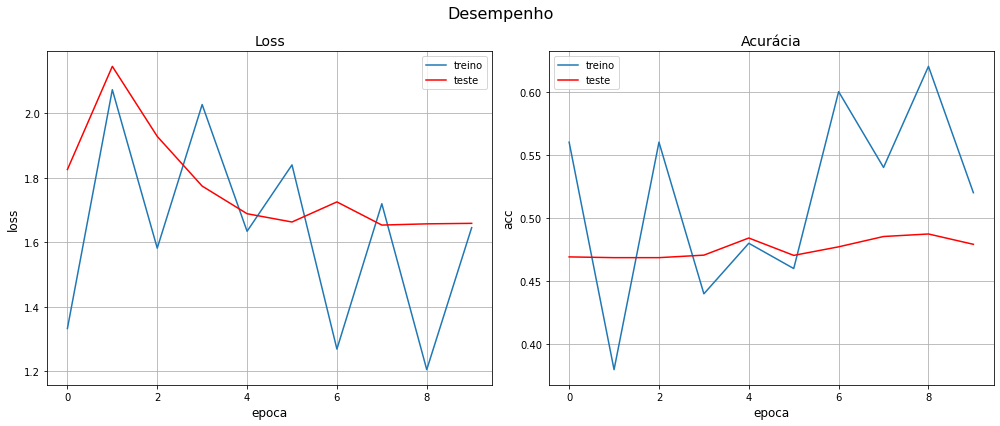

In [46]:
plt.figure(figsize=(14, 6))
plt.suptitle('Desempenho', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('Loss', fontsize=14)
sns.lineplot(x=range(EPOCHS), y=[x.item() for x in loss_treino], hue=['treino' for _ in range(EPOCHS)])
sns.lineplot(x=range(EPOCHS), palette=['r'], y=[x.item() for x in loss_teste], hue=['teste' for _ in range(EPOCHS)])
plt.xlabel('epoca', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Acurácia', fontsize=14)
sns.lineplot(x=range(EPOCHS), y=acc_treino, hue=['treino' for _ in range(EPOCHS)])
sns.lineplot(x=range(EPOCHS), y=acc_teste, palette=['r'], hue=['teste' for _ in range(EPOCHS)])
plt.xlabel('epoca', fontsize=12)
plt.ylabel('acc', fontsize=12)
plt.grid()

plt.tight_layout()
plt.show()

In [48]:
def predict(nome, top=3):
    tns = nome2tensor(nome)
    saida = modelo(tns)
    probas, idxs = saida.data.topk(top, 1, True)#, True)
    for proba,arg in zip(*probas, *idxs):
        p = proba.item()
        a = arg.item()
        c = classes[arg.item()]
        print(f'Proba: {p:.2f}\tClasse: {a}\tLabel: {c}')
    print()

In [51]:
for i in range(3):
    n, nac, = choice(df[['nome', 'nac']].values)
    print(f'{n} [{nac}]')
    predict(n)

Fernyhough [english]
Proba: -0.14	Classe: 14	Label: russian
Proba: -3.12	Classe: 4	Label: english
Proba: -4.23	Classe: 3	Label: dutch

Toma [arabic]
Proba: -1.58	Classe: 14	Label: russian
Proba: -1.90	Classe: 4	Label: english
Proba: -2.12	Classe: 0	Label: arabic

Yuschak [russian]
Proba: -0.23	Classe: 14	Label: russian
Proba: -2.76	Classe: 4	Label: english
Proba: -3.71	Classe: 10	Label: japanese



___
## Análise de Sentimentos

In [102]:
import os

from torchtext import data, datasets
from torchtext.legacy.data import Field  # curso está defasado

In [115]:
if os.system('python3 -m spacy download en_core_web_sm') != 0:
    raise ConnectionError('Não foi possível fazer o download!')

ConnectionError: Não foi possível fazer o download!

In [110]:
try:
    TEXT = Field(tokenize='spacy', include_lengths=True)
    LABEL = Field(dtype=torch.long)
except Exception as e:
    print(e)

[E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.


In [109]:
try:
    xytrain, xytest = datasets.IMDB()   # curso está defasado
except Exception as e:
    print(e)

('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))


### ...

$\blacksquare$ cqd